(-0.7, 1.7)

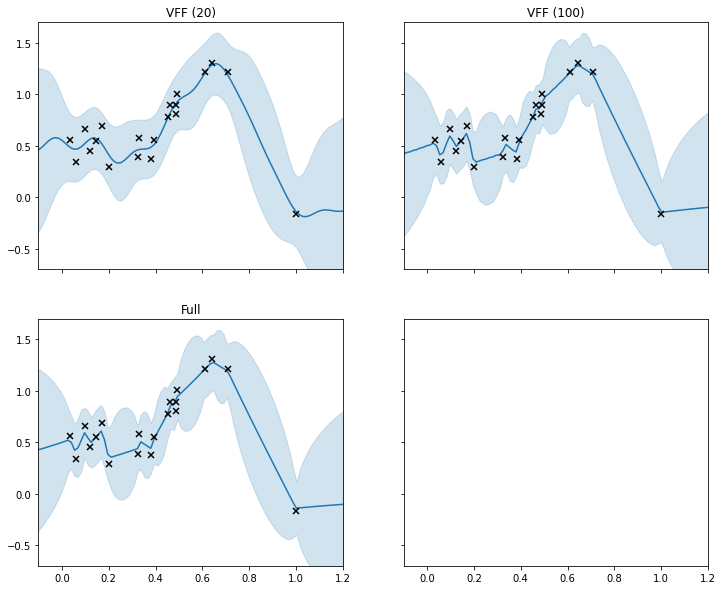

In [16]:
# Copyright 2016 James Hensman
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
from turtle import clear
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import gpflow
import VFF

plt.ion()
# import matplotlib2tikz
plt.close("all")

X = np.vstack([np.random.rand(10, 1), np.random.rand(10, 1) * 0.5])
Y = np.sin(3 * X) + 0.4 * np.cos(9 * X) + 0.1 * np.random.randn(*X.shape)

# whether or not to optimize the parameters of the models. If False, use optimial parameters from ful model.
optimize = False


def plot(m, X, Y, ax=None):
    if ax is None:
        f, ax = plt.subplots(1, 1)
    xtest = np.linspace(-0.2, 1.2, 100)[:, None]
    mu, var = m.predict_y(xtest)
    (line,) = ax.plot(xtest, mu, "C0", lw=1.5)
    ax.fill_between(xtest.reshape(-1), tf.reshape(mu - 2 * np.sqrt(var), (-1)), tf.reshape(mu + 2 * np.sqrt(var), (-1)), color="C0", alpha=0.2)
    ax.plot(X, Y, "kx", mew=1.5)


# build a full model to get hypers.
k = gpflow.kernels.Matern12
m_full = gpflow.models.GPR(data=(X, Y), kernel=k(1), mean_function=None)
opt = gpflow.optimizers.Scipy()
opt.minimize(m_full.training_loss, m_full.trainable_variables)

f, axes = plt.subplots(2, 2, figsize=(12,10), sharex=True, sharey=True)
axes = axes.flatten()
ax_count = 0
# for M in [20, 100, 500]:
#     m = VFF.SSGP(X, Y, kern=K(1), num_basis=M)
#     m.omega.fixed = True
#     m.kern.set_parameter_dict(m_full.kern.get_parameter_dict())
#     m.likelihood.set_parameter_dict(m_full.likelihood.get_parameter_dict())
#     if optimize:
#         m.optimize()
#     plot(m, axes[ax_count])
#     axes[ax_count].set_title("RFF (%i)" % M)
#     ax_count += 1

for M in [20, 100]:
    m = VFF.gpr.GPR_1d(data=(X, Y), ms=np.arange(M), a=-1, b=2, kernel=k(1))
    m.kernel.lengthscales.assign(m_full.kernel.lengthscales)
    m.kernel.variance.assign(m_full.kernel.variance)
    m.likelihood.variance.assign(m_full.likelihood.variance)
    if optimize:
        m.optimize()
    plot(m, X, Y, axes[ax_count])
    axes[ax_count].set_title("VFF (%i)" % M)
    ax_count += 1

plot(m_full, X, Y, axes[ax_count])
axes[ax_count].set_title("Full")
axes[ax_count].set_xlim(-0.1, 1.2)
axes[ax_count].set_ylim(-0.7, 1.7)